In [1]:
import numpy as np
import matplotlib.pyplot as plt
import axion_motion
import clock_work_axion
import model
import transport_equation
import reheating
from common import constants, cosmology

In [2]:
Gamma_phi = 1e7
H_inf = 2e10
mR = 6
m_phi = 100 * 1e-9 # [GeV]

t0, initial = reheating.calc_initial_reheating(H_inf)
tf = t0*1e7
M = m_phi / np.exp(- np.pi * mR)
params = (mR, M)
T_osc = (90 * constants.M_pl**2 * m_phi**2 / (constants.g_star * np.pi**2))**(1/4)

In [80]:
%time T_fn, H_fn, T_dot_fn, final = reheating.solve_reheating_eq(t0, tf, initial, Gamma_phi)
%time sol = axion_motion.solve_axion_motion(clock_work_axion.clock_work_rhs, (1, 0), t0, tf, T_fn, H_fn, params, 1e-4, "Radau")

CPU times: user 11.2 ms, sys: 0 ns, total: 11.2 ms
Wall time: 8.7 ms
CPU times: user 143 ms, sys: 0 ns, total: 143 ms
Wall time: 143 ms


Text(0, 0.5, 'H / GeV')

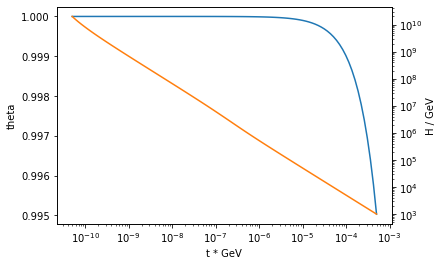

In [4]:
t_range = np.geomspace(t0, tf, 100)
plt.semilogx(t_range, sol(np.log(t_range))[0])
plt.ylabel("theta")
plt.xlabel("t * GeV")
ax2 = plt.twinx()
ax2.loglog(t_range, H_fn(t_range), color="tab:orange")
#ax2.axhline(m_phi, color="black", ls="--")
ax2.set_ylabel("H / GeV")

Text(0, 0.5, 'T_osc / GeV')

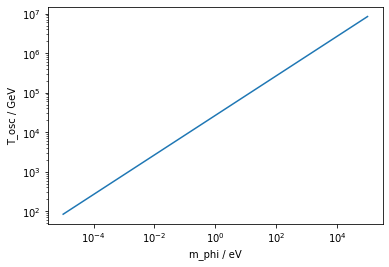

In [5]:
m_phi_range = np.geomspace(1e-5, 1e5, 100) * 1e-9
plt.loglog(m_phi_range * 1e9, (90 * constants.M_pl**2 * m_phi_range**2 / (constants.g_star * np.pi**2))**(1/4))
plt.xlabel("m_phi / eV")
plt.ylabel("T_osc / GeV")

In [6]:
from scipy.special import ellipj, ellipk, ellipkinc, ellipkm1
def sc(x, y):
    sn, cn, _dn, _ph = ellipj(x, y)
    return sn / cn

In [210]:
def calc_eps(mR):
    return np.exp(- np.pi * mR)

def calc_m_phi(mR, M):
    return calc_eps(mR) * M

def calc_u(phi_over_f, eps):
    return eps * sc(phi_over_f / 2, 1 - eps**2)

def calc_V_eff_over_f_sq(phi_over_f, eps, M):
    return M**2 * 2 / (1 + 1 / calc_u(phi_over_f, eps)**2)

def theta_to_phi_over_f(theta, eps):
    return 2 / eps * ellipkinc(theta / 2, - 1 / eps**2)

In [175]:
def calc_du_dphi_times_f(phi_over_f, eps):
    _sn, cn, dn, _ph = ellipj(phi_over_f / 2, 1 - eps**2)
    return eps / 2 * dn / cn**2

def calc_dV_eff_dphi_over_f(phi_over_f, eps, M):
    u = calc_u(phi_over_f, eps)
    return 4 * M**2 * calc_du_dphi_times_f(phi_over_f, eps) / (u**3 * (1 + 1 / u**2)**2)

In [176]:
def rhs(t, y, eps, M, H_fn):
    phi_over_f, phi_dot_over_f = y
    H = H_fn(t)
    phi_dot_dot_over_f = - 3 * H * phi_dot_over_f - calc_dV_eff_dphi_over_f(phi_over_f, eps, M)
    return phi_dot_over_f, phi_dot_dot_over_f

In [177]:
def make_rad_dom_H_fn(t_init, T_init):
    T_fn = lambda t: T_init * (t / t_init)**(-0.5)
    H_fn = lambda t: 1 / (2*t)
    return T_fn, H_fn

In [178]:
def calc_theta_dot(phi_over_f, phi_dot_over_f, eps, M):
    MM = 2*M**2
    A = calc_V_eff_over_f_sq(phi_over_f, M) / MM
    return (
        1 / MM * np.abs(calc_dV_eff_dphi_over_f(phi_over_f, eps, M)) * phi_dot_over_f
        / ((1 - A)*A)**0.5
    )

In [179]:
def calc_f_eff(f, eps):
    return 2 / np.pi * f * ellipkm1(eps**2)

In [180]:
from scipy.integrate import solve_ivp

In [181]:
eps = calc_eps(mR)
f = 1e12
f_eff = calc_f_eff(f, eps)

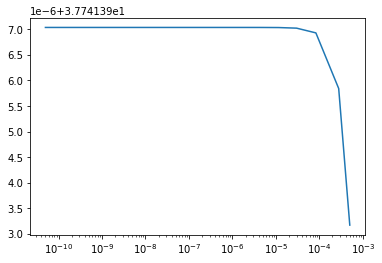

In [240]:
def evolve(t_start, t_end, initial, args, steps=None):
    sol = solve_ivp(rhs, (t_start, t_end), initial, t_eval=steps, method="Radau", args=args)
    assert sol.success
    return sol

sol_sbg = evolve(t0, tf, (theta_to_phi_over_f(1.0, eps), 0), (eps, M, H_fn))
plt.semilogx(sol_sbg.t, sol_sbg.y[0])

Text(0, 0.5, 'V_eff / GeV^4')

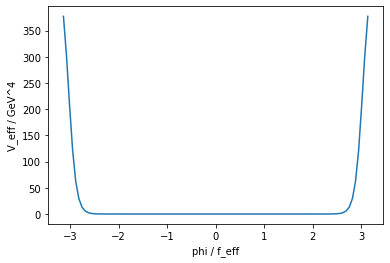

In [201]:
theta_range = np.linspace(-np.pi, np.pi, 100)
phi_over_f_range = f_eff * theta_range / f # not a linear map
plt.plot(theta_range, calc_V_eff_over_f_sq(phi_over_f_range, eps, M))
plt.xlabel("phi / f_eff")
plt.ylabel("V_eff / GeV^4")

In [184]:
t_osc = cosmology.switch_hubble_and_time_rad_dom(cosmology.calc_hubble_parameter(cosmology.calc_entropy_density(T_osc)))

In [185]:
T_fn_rad_dom, H_fn_rad_dom = make_rad_dom_H_fn(tf, T_fn(tf))

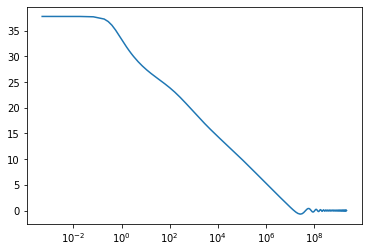

In [209]:
sol_relic = evolve(tf, t_osc, sol_sbg.y[:, -1], (eps, M, H_fn_rad_dom))
plt.semilogx(sol_relic.t, sol_relic.y[0])

In [199]:
def calc_abundance(phi_over_f, phi_dot_over_f, T, eps, f, M):
    rho = f**2 * (0.5 * phi_dot_over_f**2 + calc_V_eff_over_f_sq(phi_over_f, eps, M))
    n = rho / m_phi
    s = cosmology.calc_entropy_density(T)
    return n / s

Text(0, 0.5, 'Y')

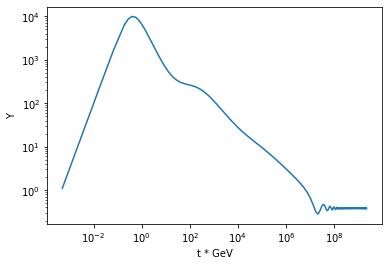

In [200]:
Y = calc_abundance(*sol_relic.y, T_fn_rad_dom(sol_relic.t), eps, f, M)
plt.loglog(sol_relic.t, Y)
plt.xlabel("t * GeV")
plt.ylabel("Y")

In [250]:
def compute_relic_density(field_initial_over_f, T_initial, t_initial, f, mR, M, 
                          num_osc_per_step=10, convergence_epsilon=1e-3, debug=False):
    T_fn_rad_dom, H_fn_rad_dom = make_rad_dom_H_fn(t_initial, T_initial)
    m_phi = calc_m_phi(mR, M)
    t_osc = cosmology.switch_hubble_and_time_rad_dom(m_phi)
    Delta_t = 2*np.pi / m_phi * num_osc_per_step 
    eps = calc_eps(mR)
    args = (eps, M, H_fn)
    sol = evolve(t_initial, t_osc, field_initial_over_f, args)
    change = 1
    while change > convergence_epsilon:
        t_start = sol.t[-1]
        t_end = t_start + Delta_t
        t_steps = np.linspace(t_start, t_end, num_osc_per_step * 10)
        t_steps[0] = t_start; t_steps[-1] = t_end
        sol = evolve(t_start, t_end, sol.y[:, -1], args, steps=t_steps)
        Y = calc_abundance(*sol.y, T_fn(sol.t), eps, f, M)
        Y_max, Y_min = np.max(Y), np.min(Y)
        change = Y_max - Y_min
        if debug:
            print("change:", change, "Y_mean:", Y_mean, "convergence_eps:", convergence_epsilon)
    Y = (Y_max + Y_min) / 2
    n_today = Y * cosmology.calc_entropy_density(constants.T_CMB)
    rho_today = m_phi * n_today
    Omega_h_sq = rho_today / rho_c * h**2
    return Omega_h_sq

In [249]:
compute_relic_density(sol_sbg.y[:, -1], T_fn(sol_sbg.t[-1]), sol_sbg.t[-1], f, mR, M)

2.4311837573542277e-09